#  Import The Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import patsy
from statistics import mean

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge, Lasso, LassoCV ,RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)

# Collection data (Web Scraping by beautifulsoup)

Sources we Collection from are www.sa.aqar.fm and www.propertyfinder.sa

- The First source collection:

In [ ]:
villa_list_aqar=[]
Area_Of_villa=[]
i=1

while i<100:
    url = f"https://sa.aqar.fm/%D9%81%D9%84%D9%84-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/{i}"
    res=requests.get(url)
    if res.status_code==200:
        p=res.text
        soup=BeautifulSoup(p,"lxml")
        i+=1
        
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "Num_Of_Bedrooms", "Num_Of_Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            villa_list_aqar.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    Area_Of_villa.append(x)
    else:
        break

In [ ]:

len(Area_Of_villa)

In [ ]:
len(villa_list_aqar)

In [ ]:
villa_aqar_DF=pd.DataFrame(villa_list_aqar)
villa_aqar_DF

In [ ]:
Area_villa_DF=pd.DataFrame(Area_Of_villa)
Area_villa_DF

In [ ]:
villa_aqar_DF["StreetWidth"]=Area_villa_DF
villa_aqar_DF

In [ ]:
# list villaDF in Riyadh city
villa_aqar_DF= villa_aqar_DF[villa_aqar_DF.District.str.contains("الرياض") == True]
villa_aqar_DF

In [ ]:
# All District without ("حي الرمال - الرياض")
villa_aqar_DF= villa_aqar_DF[villa_aqar_DF.District.str.contains("حي الرمال - الرياض") == False]
villa_aqar_DF

In [ ]:
houses_list_aqar = []
Area_Of_houses=[]

i = 1
while i < 200:
    url = f"https://sa.aqar.fm/%D8%A8%D9%8A%D8%AA-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6/{i}" 
    response = requests.get(url)
    if response.status_code == 200:
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        i += 1
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "Num_Of_Bedrooms", "Num_Of_Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list_aqar.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    Area_Of_houses.append(x)
    else:
        break

In [ ]:
len(houses_list_aqar)

In [ ]:
len(Area_Of_houses)

In [ ]:
houses_aqar_DF = pd.DataFrame(houses_list_aqar)
houses_aqar_DF.head()

In [ ]:
Area_houses_DF=pd.DataFrame(Area_Of_houses)
Area_houses_DF

In [ ]:
houses_aqar_DF["StreetWidth"]=Area_houses_DF
houses_aqar_DF

- The Second source collection:

In [ ]:
houses_list_of_propertyfinder = []
i = 1
while i < 100:
    url_of_propertyfinder = f"https://www.propertyfinder.sa/ar/search?c=1&ob=mr&page=1&t=35" 
    response_of_propertyfinder = requests.get(url_of_propertyfinder)
    if response_of_propertyfinder.status_code == 200:
        page_of_propertyfinder = response_of_propertyfinder.text
        soup_of_propertyfinder = BeautifulSoup(page_of_propertyfinder, "lxml")
        i += 1
        houses_of_propertyfinder=soup_of_propertyfinder.find_all("div", {"class":"card-list__item"})#class name of div of each house
        headers_of_propertyfinder = ["Price", "Num_Of_Bedrooms", "Num_Of_Bathrooms", "Size(m²)","District"]
        
        for house in houses_of_propertyfinder:
            price = float(house.find(class_="card__price-value").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="card__property-amenity card__property-amenity--bedrooms").text.replace("+", "").replace("عدد الغرف","").strip())
            bath = int(house.find(class_="card__property-amenity card__property-amenity--bathrooms").text.replace("+", "").replace("حمامات","").strip())
            size = float(house.find(class_="card__property-amenity card__property-amenity--area").text.replace("متر مربع", "").replace(",", "").strip())
            districts = house.find(class_="card__location-text").text.replace("حي الملقا","الملقا").strip()
            house_dict_of_propertyfinder = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list_of_propertyfinder.append(house_dict_of_propertyfinder)
    else:
        break

In [ ]:
len(houses_list_of_propertyfinder)

In [ ]:
houses_propertyfinder_DF = pd.DataFrame(houses_list_of_propertyfinder)

- Collect data from both sources into one DF (Sale_DF)

In [ ]:
Sale_DF = pd.concat([villa_aqar_DF, houses_aqar_DF, houses_propertyfinder_DF])
Sale_DF

# Save data in excel file

In [ ]:
Sale_DF.to_excel("aqar.xlsx")

In [3]:
Sale_DF= pd.read_excel ('aqar.xlsx')

# Data Preprocessing

In [4]:
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3033 entries, 0 to 3032
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        3033 non-null   int64 
 1   Price             3033 non-null   int64 
 2   Num_Of_Bedrooms   3033 non-null   int64 
 3   Num_Of_Bathrooms  3033 non-null   int64 
 4   Size(m²)          3033 non-null   int64 
 5   District          3033 non-null   object
 6   StreetWidth       3033 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 166.0+ KB


In [5]:
Sale_DF.isnull().sum()

Unnamed: 0          0
Price               0
Num_Of_Bedrooms     0
Num_Of_Bathrooms    0
Size(m²)            0
District            0
StreetWidth         0
dtype: int64

- drop null value

In [6]:
Sale_DF=Sale_DF.dropna()

In [7]:
Sale_DF.isnull().sum()

Unnamed: 0          0
Price               0
Num_Of_Bedrooms     0
Num_Of_Bathrooms    0
Size(m²)            0
District            0
StreetWidth         0
dtype: int64

In [8]:
Sale_DF["StreetWidth"].isna().sum()

0

- drop zero value

In [9]:
Sale_DF.loc[~(Sale_DF==0).all(axis=1)]

,Unnamed: 0,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,0,1400000,5,5,510,الروضة,20
1,1,1400000,5,5,375,المنصورة,15
2,2,2500000,5,5,700,المنار,36
3,3,2700000,4,5,375,النرجس,15
4,4,3000000,7,5,600,اليرموك,20
...,...,...,...,...,...,...,...
3028,3028,300000,5,5,185,سلطانة,20
3029,3029,2000000,5,5,450,ظهرة لبن,20
3030,3030,1850000,4,4,625,النظيم,20
3031,3031,1450000,5,5,750,الشفا,20


In [10]:
#check for zero value and saved in other DF
Sale_DF2 = Sale_DF.all()
Sale_DF2

Unnamed: 0          False
Price                True
Num_Of_Bedrooms      True
Num_Of_Bathrooms     True
Size(m²)             True
District             True
StreetWidth          True
dtype: bool

In [11]:
Sale_DF.columns=Sale_DF.columns.str.strip()
Sale_DF.drop(columns=Sale_DF.columns[0], 
        axis=1, 
        inplace=True)
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1400000,5,5,510,الروضة,20
1,1400000,5,5,375,المنصورة,15
2,2500000,5,5,700,المنار,36
3,2700000,4,5,375,النرجس,15
4,3000000,7,5,600,اليرموك,20
...,...,...,...,...,...,...
3028,300000,5,5,185,سلطانة,20
3029,2000000,5,5,450,ظهرة لبن,20
3030,1850000,4,4,625,النظيم,20
3031,1450000,5,5,750,الشفا,20


In [12]:
Sale_DF.head()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1400000,5,5,510,الروضة,20
1,1400000,5,5,375,المنصورة,15
2,2500000,5,5,700,المنار,36
3,2700000,4,5,375,النرجس,15
4,3000000,7,5,600,اليرموك,20


In [13]:
Sale_DF.sample(5)

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
2189,600000,5,4,315,بنبان,10
2395,600000,5,4,315,بنبان,6
2328,1350000,5,4,300,طويق,6
2877,2500000,5,5,816,الخليج,10
522,1800000,7,5,500,القيروان,15


In [14]:
Sale_DF.tail()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
3028,300000,5,5,185,سلطانة,20
3029,2000000,5,5,450,ظهرة لبن,20
3030,1850000,4,4,625,النظيم,20
3031,1450000,5,5,750,الشفا,20
3032,900000,5,5,400,الدار البيضاء,15


In [15]:
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033 entries, 0 to 3032
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             3033 non-null   int64 
 1   Num_Of_Bedrooms   3033 non-null   int64 
 2   Num_Of_Bathrooms  3033 non-null   int64 
 3   Size(m²)          3033 non-null   int64 
 4   District          3033 non-null   object
 5   StreetWidth       3033 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 165.9+ KB


- "District" will be split to name of (الأحياء)

In [16]:
Sale_DF['District'] = Sale_DF['District'].str.split(" - ", n = 1, expand = True)
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1400000,5,5,510,الروضة,20
1,1400000,5,5,375,المنصورة,15
2,2500000,5,5,700,المنار,36
3,2700000,4,5,375,النرجس,15
4,3000000,7,5,600,اليرموك,20
...,...,...,...,...,...,...
3028,300000,5,5,185,سلطانة,20
3029,2000000,5,5,450,ظهرة لبن,20
3030,1850000,4,4,625,النظيم,20
3031,1450000,5,5,750,الشفا,20


In [17]:
Sale_DF['District'] = Sale_DF['District'].str.split(", ", n = 1, expand = True)
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1400000,5,5,510,الروضة,20
1,1400000,5,5,375,المنصورة,15
2,2500000,5,5,700,المنار,36
3,2700000,4,5,375,النرجس,15
4,3000000,7,5,600,اليرموك,20
...,...,...,...,...,...,...
3028,300000,5,5,185,سلطانة,20
3029,2000000,5,5,450,ظهرة لبن,20
3030,1850000,4,4,625,النظيم,20
3031,1450000,5,5,750,الشفا,20


In [18]:
Sale_DF['District'] = Sale_DF['District'].str.replace("حي ", "")
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1400000,5,5,510,الروضة,20
1,1400000,5,5,375,المنصورة,15
2,2500000,5,5,700,المنار,36
3,2700000,4,5,375,النرجس,15
4,3000000,7,5,600,اليرموك,20
...,...,...,...,...,...,...
3028,300000,5,5,185,سلطانة,20
3029,2000000,5,5,450,ظهرة لبن,20
3030,1850000,4,4,625,النظيم,20
3031,1450000,5,5,750,الشفا,20


In [19]:
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033 entries, 0 to 3032
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             3033 non-null   int64 
 1   Num_Of_Bedrooms   3033 non-null   int64 
 2   Num_Of_Bathrooms  3033 non-null   int64 
 3   Size(m²)          3033 non-null   int64 
 4   District          3033 non-null   object
 5   StreetWidth       3033 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 165.9+ KB


In [20]:
Sale_DF.shape

(3033, 6)

In [21]:
Sale_DF.sample(5)

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
2314,950000,5,5,390,عكاظ,20
226,1150000,1,5,300,طويق,25
245,1200000,5,3,200,ظهرة لبن,20
654,1900000,5,3,560,العليا,15
2531,1650000,5,5,560,النظيم,12


- Convert type of (Num_Of_Bedrooms and Num_Of_Bathrooms) from float to int

In [22]:
Sale_DF['Num_Of_Bedrooms'] = Sale_DF['Num_Of_Bedrooms'].astype(float, errors = 'raise')
Sale_DF['Num_Of_Bathrooms'] = Sale_DF['Num_Of_Bathrooms'].astype(float, errors = 'raise')
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033 entries, 0 to 3032
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             3033 non-null   int64  
 1   Num_Of_Bedrooms   3033 non-null   float64
 2   Num_Of_Bathrooms  3033 non-null   float64
 3   Size(m²)          3033 non-null   int64  
 4   District          3033 non-null   object 
 5   StreetWidth       3033 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 165.9+ KB


- drop duplicate value

In [23]:
Sale_DF[Sale_DF.index.duplicated()]

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth


In [24]:
Sale_DF.columns.duplicated().any()

False

In [25]:
Sale_DF= Sale_DF.loc[~Sale_DF.index.duplicated(), :]

In [26]:
Sale_DF.shape

(3033, 6)

In [27]:
Sale_DF.describe()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
count,3.033000e+03,3033.000000,3033.000000,3033.000000,3033.000000
mean,1.292126e+06,4.841081,4.377184,396.580613,15.562479
std,6.516455e+05,0.782687,0.956594,172.558600,6.619124
min,1.800000e+05,1.000000,1.000000,125.000000,1.000000
25%,8.700000e+05,5.000000,4.000000,280.000000,10.000000
50%,1.250000e+06,5.000000,5.000000,375.000000,15.000000
75%,1.700000e+06,5.000000,5.000000,450.000000,20.000000
max,3.450000e+06,7.000000,5.000000,933.000000,100.000000


# OUTLIERS

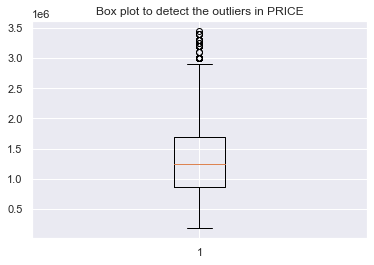

In [28]:
plt.boxplot(Sale_DF["Price"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

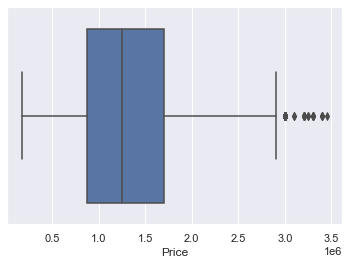

In [29]:
sns.boxplot(Sale_DF['Price']);

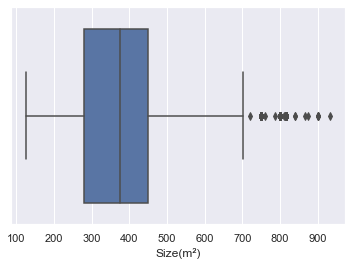

In [30]:
sns.boxplot(Sale_DF['Size(m²)']);

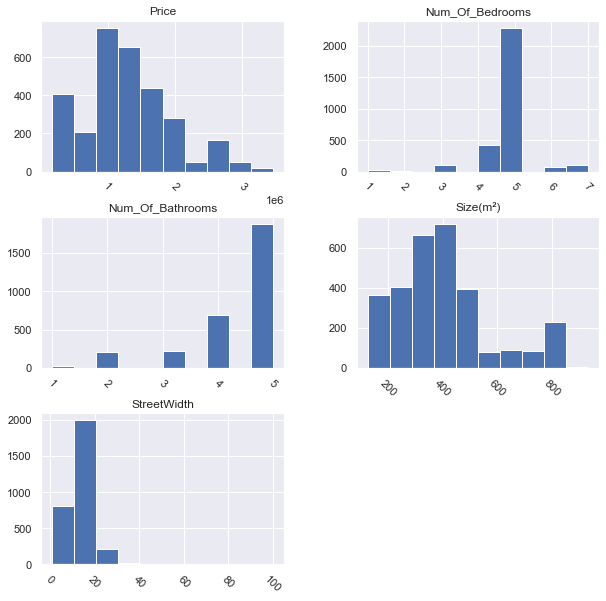

In [31]:
# Plot histogram grid
Sale_DF.hist(figsize=(10,10), xrot=-45);

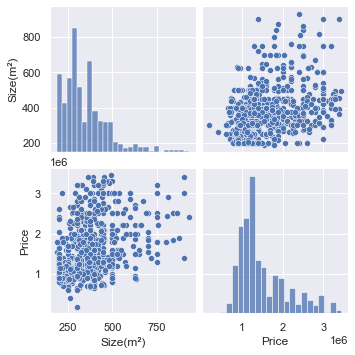

In [32]:
sns.pairplot(Sale_DF[['Size(m²)','Price']][:1000]);

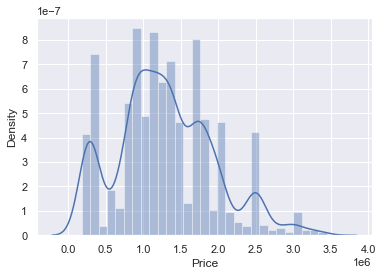

In [33]:
sns.distplot(Sale_DF['Price']);

In [34]:
# OUTLIERS
q2 = Sale_DF.Price.quantile(q=0.4)
q1 = Sale_DF.Price.quantile(q=0.1)
IQR = q2 -  q1
OUTLIER = q2 + 1.5 * IQR
OUTLIER

2300000.0

<AxesSubplot:xlabel='Price'>

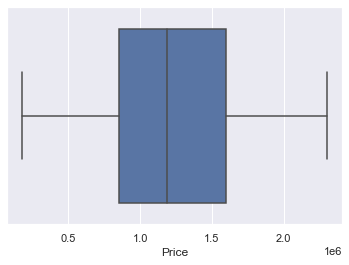

In [35]:
#PLOTTING THE BOX PLOT EXCLUDING THE OUTLIERS
sns.boxplot( Sale_DF[Sale_DF.Price<=OUTLIER].Price)

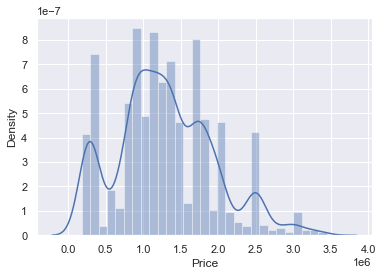

In [36]:
sns.distplot(Sale_DF['Price']);

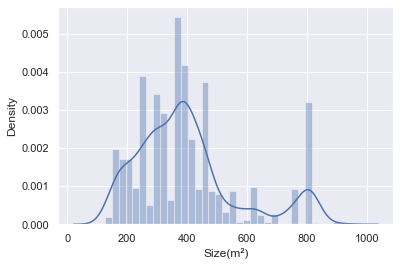

In [37]:
sns.distplot(Sale_DF['Size(m²)']);

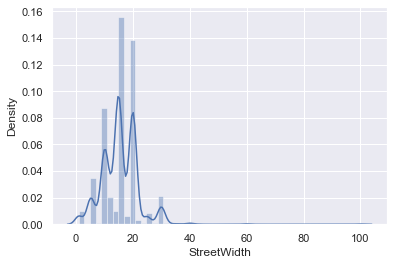

In [38]:
sns.distplot(Sale_DF['StreetWidth']);

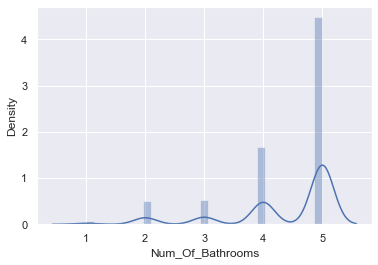

In [39]:
sns.distplot(Sale_DF['Num_Of_Bathrooms']);

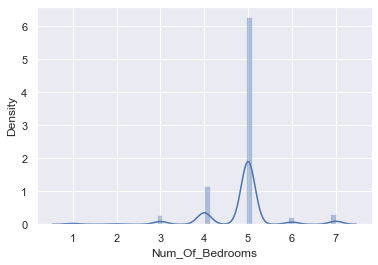

In [40]:
sns.distplot(Sale_DF['Num_Of_Bedrooms']);

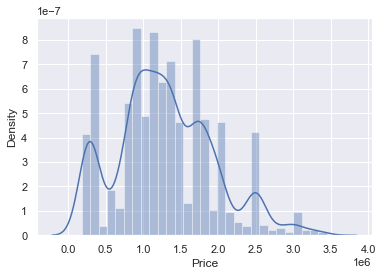

In [41]:
sns.distplot(Sale_DF['Price']);

In [42]:
# top 10
Sale_DF['District'].value_counts().head(10)

طويق              692
ظهرة لبن          263
الدار البيضاء     197
منفوحة الجديدة    172
النظيم            157
الخليج            123
الشميسي           115
بنبان             111
عكاظ              105
القادسية           95
Name: District, dtype: int64

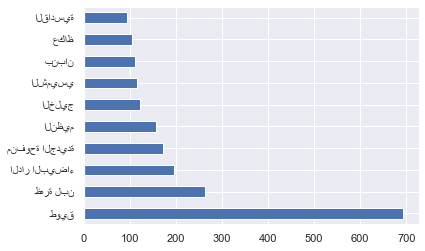

In [43]:
Sale_DF['District'].value_counts()[:10].plot(kind='barh');

In [44]:
Top_District =Sale_DF[['District' ,'Price']].groupby('District').mean().reset_index().sort_values(by = 'Price', ascending = False)
Top_District.head(10)

,District,Price
70,الواحة,3.300000e+06
68,النفل,3.000000e+06
46,القدس,2.933333e+06
74,الياسمين,2.895464e+06
56,الملقا,2.685714e+06
97,قرطبة,2.650000e+06
63,النرجس,2.605278e+06
51,المروج,2.550000e+06
59,المنار,2.500000e+06
5,التعاون,2.408333e+06


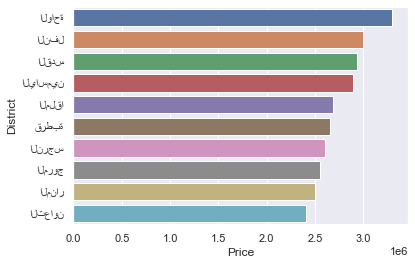

In [45]:
sns.barplot(data=Top_District.head(10), x='Price',y='District', palette = 'deep');

In [46]:
Sale_DF.describe()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
count,3.033000e+03,3033.000000,3033.000000,3033.000000,3033.000000
mean,1.292126e+06,4.841081,4.377184,396.580613,15.562479
std,6.516455e+05,0.782687,0.956594,172.558600,6.619124
min,1.800000e+05,1.000000,1.000000,125.000000,1.000000
25%,8.700000e+05,5.000000,4.000000,280.000000,10.000000
50%,1.250000e+06,5.000000,5.000000,375.000000,15.000000
75%,1.700000e+06,5.000000,5.000000,450.000000,20.000000
max,3.450000e+06,7.000000,5.000000,933.000000,100.000000


# counting correlation

In [47]:
Sale_DF.corr()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
Price,1.000000,-0.015048,0.330657,0.621290,0.043085
Num_Of_Bedrooms,-0.015048,1.000000,0.244396,0.059411,0.021271
Num_Of_Bathrooms,0.330657,0.244396,1.000000,0.207231,0.031697
Size(m²),0.621290,0.059411,0.207231,1.000000,-0.101476
StreetWidth,0.043085,0.021271,0.031697,-0.101476,1.000000


In [48]:
Sale_DF.cov()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
Price,4.246419e+11,-7674.930638,206118.803694,6.986223e+07,185840.538555
Num_Of_Bedrooms,-7.674931e+03,0.612599,0.182982,8.024029e+00,0.110196
Num_Of_Bathrooms,2.061188e+05,0.182982,0.915073,3.420738e+01,0.200700
Size(m²),6.986223e+07,8.024029,34.207381,2.977647e+04,-115.904197
StreetWidth,1.858405e+05,0.110196,0.200700,-1.159042e+02,43.812800


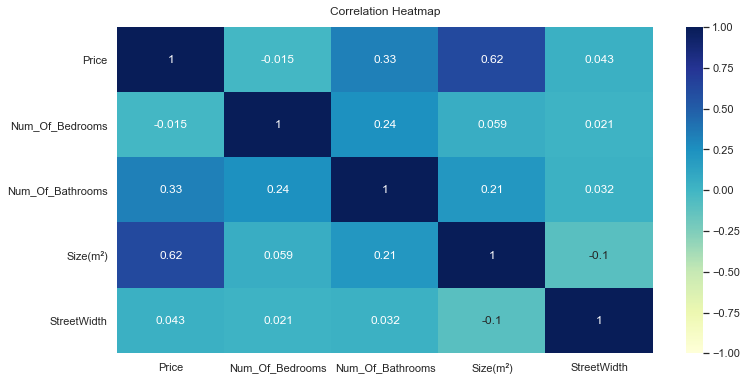

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(Sale_DF.corr(), vmin=-1, vmax=1, annot=True,cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()
plt.savefig('Correlation Heatmap.png')

- The "Size" feature has high positive correlation 0.67 with our target "Price"
- The "Num_Of_Bathrooms" feature has positive correlation 0.33 with our target "Price"
- The "Num_Of_Bedrooms" feature has low positive correlation 0.037 with our target "Price"

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


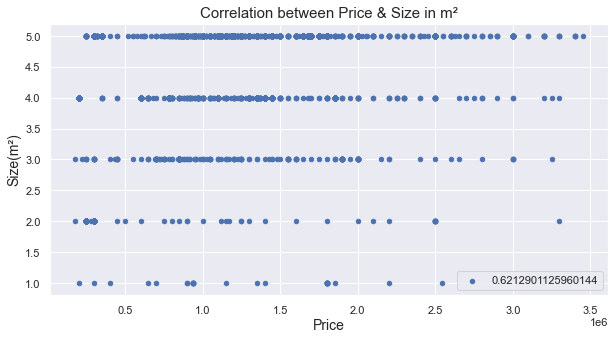

In [50]:
corr = Sale_DF["Price"].corr(Sale_DF['Size(m²)']) 
Sale_DF.plot(kind="scatter",y="Num_Of_Bathrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("Size(m²)" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


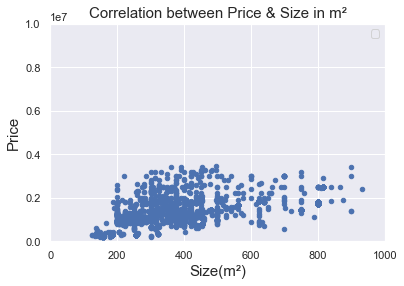

In [51]:
#Zoomed in plot for the price vs size(m2)

Sale_DF.plot(x="Size(m²)", y='Price', kind='scatter')
plt.xlim([0, 1000])
plt.ylim([0,1e7])
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Size(m²)" , fontsize=15)
plt.ylabel("Price" , fontsize=15)
plt.legend();

In [52]:
Sale_DF.Price.describe()

count    3.033000e+03
mean     1.292126e+06
std      6.516455e+05
min      1.800000e+05
25%      8.700000e+05
50%      1.250000e+06
75%      1.700000e+06
max      3.450000e+06
Name: Price, dtype: float64

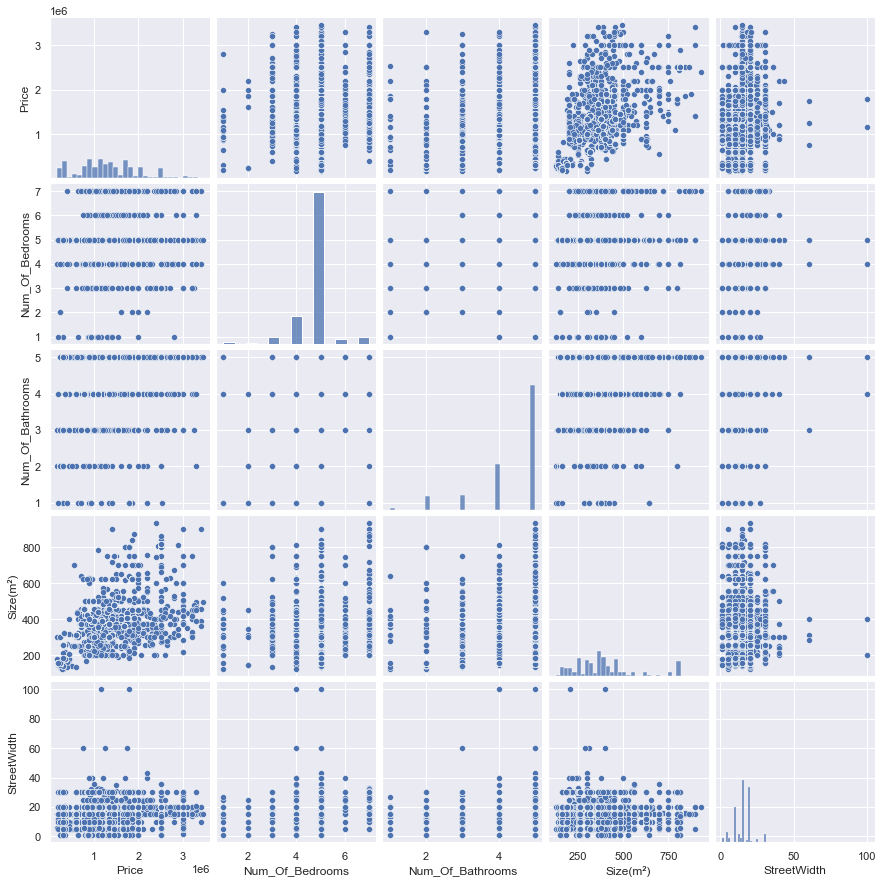

In [53]:
sns.pairplot(Sale_DF);

# Save data in excel file

In [54]:
Sale_DF.to_excel("aqar.xlsx")

In [55]:
Sale_DF= pd.read_excel ('aqar.xlsx')

# Model Building

# Setting up for modeling:

In [56]:
#Split the data 60 - 20 - 20 train/val/test
X_train, X_test, y_train, y_test = train_test_split(Sale_DF[['Size(m²)']], Sale_DF[['Price']], test_size=0.3, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [57]:
y_train.columns

Index(['Price'], dtype='object')

In [58]:
X_train.columns

Index(['Size(m²)'], dtype='object')

In [59]:
print("Training Data has",X_train.shape)
print("Testing Data has",X_test.shape)
print("Validation Data has",X_val.shape)

Training Data has (1486, 1)
Testing Data has (910, 1)
Validation Data has (637, 1)


# Modeling Housing Data with Statsmodels

In [62]:
# split into train and target
X= Sale_DF.iloc[:,1:]
y=Sale_DF['Price']

In [63]:
# fit model with target as housing price index
import statsmodels.api as sm

_model = sm.OLS(y_train, X_train, data=Sale_DF)

results =_model.fit()

# summarize our model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.866
Model:                            OLS   Adj. R-squared (uncentered):              0.866
Method:                 Least Squares   F-statistic:                              9569.
Date:                Mon, 25 Oct 2021   Prob (F-statistic):                        0.00
Time:                        15:07:14   Log-Likelihood:                         -21687.
No. Observations:                1486   AIC:                                  4.338e+04
Df Residuals:                    1485   BIC:                                  4.338e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Size(m²)    3081.2867     31.499     97.820      0.000    3019.499    3143.075
==============================================================================
Omnibus:                      191.221   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              323.512
Skew:                           0.850   Prob(JB):                     5.63e-71
Kurtosis:                       4.529   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Linear regression model

In [64]:
lm = LinearRegression() # construct LinearRegression model object
lm.fit(X_train, y_train) #fit model to features X, target y

preds = lm.predict(X_test) # generate predictions for X using fit model
pred_1=lm.predict(X_val)  # score predictions on X against ground truth target y, using fit model

# score fit model on validation data
train_score = lm.score(X_train, y_train)
val_score = lm.score(X_val, y_val)
test_score = lm.score(X_test, y_test)

# report results
print('Linear Regression training R^2:', train_score)
print('Linear Regression validation R^2:', val_score)

Linear Regression training R^2: 0.38341462503659707
Linear Regression validation R^2: 0.4077923076505007


In [65]:
print('Linear Regression Testing R^2:', test_score)

Linear Regression Testing R^2: 0.3723069191665358


In [66]:
print(lm.coef_)

[[2278.72251171]]


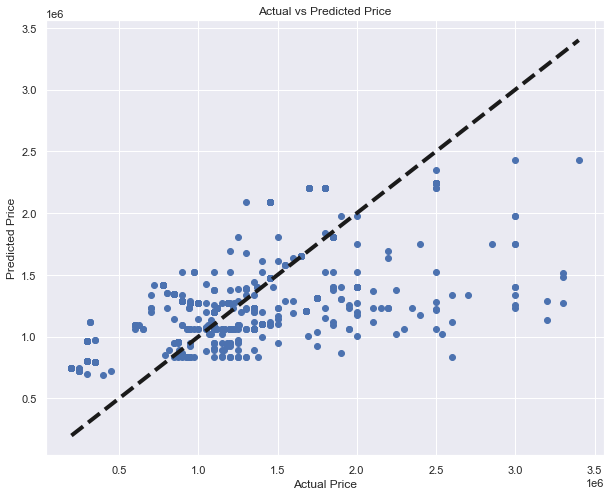

In [72]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(y_val,pred_1)
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
ax.set_title('Actual vs Predicted Price')
ax.set_xlabel('Actual Price')
ax.set_ylabel('Predicted Price')
plt.show()

# Polynomial Regression

In [73]:
for i in range(2,7):
    poly = PolynomialFeatures(degree=i)
    X_train_poly = poly.fit_transform(Sale_DF[['Price']])
    X_val_poly = poly.transform(Sale_DF[['Price']])

    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly,Sale_DF[['Price']])
    lr_poly.score(X_train_poly,Sale_DF[['Price']])
    
    print("_____________Degree ",i,"_______________")
    print("Polynomial (",i,") Regression training R^2 : ",lr_poly.score(X_train_poly,Sale_DF['Price']))
    print("Polynomial (",i,") Regression validation R^2 : ",lr_poly.score(X_val_poly, Sale_DF['Price']))

_____________Degree  2 _______________
Polynomial ( 2 ) Regression training R^2 :  1.0
Polynomial ( 2 ) Regression validation R^2 :  1.0
_____________Degree  3 _______________
Polynomial ( 3 ) Regression training R^2 :  0.9999998665989552
Polynomial ( 3 ) Regression validation R^2 :  0.9999998665989552
_____________Degree  4 _______________
Polynomial ( 4 ) Regression training R^2 :  0.9976328163738691
Polynomial ( 4 ) Regression validation R^2 :  0.9976328163738691
_____________Degree  5 _______________
Polynomial ( 5 ) Regression training R^2 :  0.9797576047317624
Polynomial ( 5 ) Regression validation R^2 :  0.9797576047317624
_____________Degree  6 _______________
Polynomial ( 6 ) Regression training R^2 :  0.9417079851784249
Polynomial ( 6 ) Regression validation R^2 :  0.9417079851784249


# dummy

In [74]:
Sale_DF_dummy = pd.get_dummies(Sale_DF, drop_first = True)

In [75]:
Sale_DF_dummy

,Unnamed: 0,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth,District_اشبيلية,District_الازدهار,District_الاندلس,District_البديعة,...,District_ظهرة نمار,District_عتيقة,District_عكاظ,District_عليشة,District_غبيرة,District_غرناطة,District_قرطبة,District_منفوحة,District_منفوحة الجديدة,District_نمار
0,0,1400000,5,5,510,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1400000,5,5,375,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2500000,5,5,700,36,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,2700000,4,5,375,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,3000000,7,5,600,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,3028,300000,5,5,185,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3029,3029,2000000,5,5,450,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3030,3030,1850000,4,4,625,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3031,3031,1450000,5,5,750,20,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


After converting the categrical coulumns into dummy, we have ended up with 106 coulumns.

In [76]:
X = Sale_DF_dummy.drop(["Price"],axis=1)
y = Sale_DF_dummy["Price"]

m = sm.OLS(y,X, data = Sale_DF_dummy)
re = m.fit()
re.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.975
Method:                 Least Squares   F-statistic:                              1133.
Date:                Mon, 25 Oct 2021   Prob (F-statistic):                        0.00
Time:                        15:08:15   Log-Likelihood:                         -41672.
No. Observations:                3033   AIC:                                  8.355e+04
Df Residuals:                    2928   BIC:                                  8.419e+04
Df Model:                         105                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Unnamed: 0                          -66.9390      6.465    -10.354      0.000     -79.616     -54.262
Num_Of_Bedrooms                    2.372e+04   6022.921      3.938      0.000    1.19e+04    3.55e+04
Num_Of_Bathrooms                   2.004e+04   5757.819      3.481      0.001    8752.123    3.13e+04
Size(m²)                           1706.0613     36.979     46.136      0.000    1633.554    1778.568
StreetWidth                         291.8321    649.798      0.449      0.653    -982.274    1565.939
District_اشبيلية                   1.097e+06   7.88e+04     13.931      0.000    9.43e+05    1.25e+06
District_الازدهار                  1.115e+06   1.37e+05      8.149      0.000    8.47e+05    1.38e+06
District_الاندلس                   1.187e+06   1.18e+05     10.032      0.000    9.55e+05    1.42e+06
District_البديعة                  -1.267e+04   1.06e+05     -0.120      0.905    -2.2e+05    1.95e+05
District_التعاون                   1.473e+06   1.36e+05     10.795      0.000    1.21e+06    1.74e+06
District_الجرادية                 -9601.4755   7.06e+04     -0.136      0.892   -1.48e+05    1.29e+05
District_الجزيرة                   2.343e+05   1.64e+05      1.428      0.154   -8.75e+04    5.56e+05
District_الجنادرية                  6.15e+05   9.27e+04      6.633      0.000    4.33e+05    7.97e+05
District_الحائر                    -9.94e+04   7.78e+04     -1.278      0.201   -2.52e+05    5.32e+04
District_الحزم                     4.083e+05   4.67e+04      8.753      0.000    3.17e+05       5e+05
District_الحمراء                   1.045e+06   1.65e+05      6.340      0.000    7.22e+05    1.37e+06
District_الخالدية                  1.181e+05   1.37e+05      0.862      0.389    -1.5e+05    3.86e+05
District_الخليج                    1.013e+06   4.35e+04     23.280      0.000    9.27e+05     1.1e+06
District_الدار البيضاء             7.984e+04   3.61e+04      2.209      0.027    8963.706    1.51e+05
District_الدريهمية                 7.582e+04   1.65e+05      0.460      0.646   -2.47e+05    3.99e+05
District_الربوة                    9.532e+05   2.32e+05      4.106      0.000    4.98e+05    1.41e+06
District_الربيع                    1.109e+06    2.3e+05      4.812      0.000    6.57e+05    1.56e+06
District_الرمال                    6.843e+05   4.22e+04     16.208      0.000    6.01e+05    7.67e+05
District_الروضة                    7.639e+05   1.09e+05      7.033      0.000    5.51e+05    9.77e+05
District_الرياض                    3.615e+05   6.84e+04      5.283      0.000    2.27e+05    4.96e+05
District_الريان                    8.709e+05   2.32e+05      3.748      0.000    4.15e+05    1.33e+06
District_الزهرة           

# Regression after dummy
Splitting the data into 3 parts: 60% training, 20% validation , 20% testing.

In [77]:
X = Sale_DF_dummy.drop(["Price"],axis=1)
y = Sale_DF_dummy["Price"]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)

In [78]:
X_train.head()

,Unnamed: 0,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth,District_اشبيلية,District_الازدهار,District_الاندلس,District_البديعة,District_التعاون,...,District_ظهرة نمار,District_عتيقة,District_عكاظ,District_عليشة,District_غبيرة,District_غرناطة,District_قرطبة,District_منفوحة,District_منفوحة الجديدة,District_نمار
1391,1391,5,4,159,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2269,2269,4,4,625,20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
306,306,3,4,375,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2348,2348,5,3,422,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2691,2691,5,5,816,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
lm = LinearRegression()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)


poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

poly3 = PolynomialFeatures(degree=3) 
X_train_poly3 = poly3.fit_transform(X_train.values)
X_val_poly3 = poly3.transform(X_val.values)
X_test_poly3 = poly3.transform(X_test.values)

lm_poly = LinearRegression()


lm_reg = Ridge(alpha=1)

lm_lasso = Lasso(alpha = 100)

In [80]:
print("Linear Regression :")
lm.fit(X_train, y_train)
print(f'Linear Regression training R^2: {lm.score(X_train,y_train):.3f}')
print(f'Linear Regression validation R^2: {lm.score(X_val, y_val):.3f}')

print("Ridge Regression :")
lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression training R^2: {lm_reg.score(X_train_scaled, y_train):.3f}')
print(f'Ridge Regression validation R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

print("Lasso Regression :")
lm_lasso.fit(X_train_scaled, y_train)
print(f'Lasso Regression training R^2: {lm_lasso.score(X_train_scaled, y_train):.3f}')
print(f'Lasso Regression validation R^2: {lm_lasso.score(X_val_scaled, y_val):.3f}')

Linear Regression :
Linear Regression training R^2: 0.887
Linear Regression validation R^2: 0.863
Ridge Regression :
Ridge Regression training R^2: 0.887
Ridge Regression validation R^2: 0.863
Lasso Regression :
Lasso Regression training R^2: 0.886
Lasso Regression validation R^2: 0.863


In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 71)
linearCV = cross_val_score(lm,X,y,cv= kf, scoring= "r2")
print("Cross validation for Linear Regression :",np.mean(linearC))

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 71)
ridgeCV = cross_val_score(lm_reg,X,y,cv= kf, scoring= "r2")
print("Cross validation for Ridge:",np.mean(ridgeC))

In [81]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 71)
lassoCV = cross_val_score(lm_lasso,X,y,cv= kf, scoring= "r2")
print("Cross validation for Linear Regression :",np.mean(lassoC))

Cross validation for Linear Regression : 0.853750515796446


# Test

In [82]:
print("Linear Regression :")
lm.fit(X, y)
print(f'Linear Regression training & validation R^2: {lm.score(X,y):.3f}')
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

print("Ridge Regression (best alpha) :")
lm_reg.fit(X, y)
print(f'Ridge Regression training & validation R^2: {lm_reg.score(X, y):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

print("Lasso Regression (best alpha) :")
lm_lasso.fit(X, y)
print(f'Lasso Regression training & validation R^2: {lm_lasso.score(X, y):.3f}')
print(f'Lasso Regression test R^2: {lm_lasso.score(X_test_scaled, y_test):.3f}')

====Linear Regression====
Linear Regression training & validation R^2: 0.885
Linear Regression test R^2: 0.812
====Ridge Regression (best alpha)====
Ridge Regression training & validation R^2: 0.876
Ridge Regression test R^2: -45.919
====Lasso Regression (best alpha)====
Lasso Regression training & validation R^2: 0.882
Lasso Regression test R^2: -62.966
